In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from dotenv import load_dotenv
import os

pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [ ]:
def read_data(path):
    return pd.read_csv(path)
load_dotenv() 
data_path = os.getenv("DATA")
df = read_data(data_path)
data_path2 = os.getenv("TRAINING_DATA")
df2 = read_data(data_path)

In [37]:
X = df_2.drop(["HATSURESI","Unnamed: 0", "Unnamed: 0.1"], axis=1)  
y = df_2["HATSURESI"]                 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shape of the resulting splits
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((154851, 31), (38713, 31), (154851,), (38713,))

In [ ]:
# Define a list of scheduled departure times in HH:MM format
sefer_saatleri = [
    "05:00", "05:10", "05:20", "05:30", "05:38", "05:45", "05:52", "06:00", "06:07", "06:14",
    "06:21", "06:28", "06:35", "06:42", "06:49", "06:56", "07:03", "07:10", "07:17", "07:24",
    "07:31", "07:38", "07:45", "07:52", "08:00", "08:08", "08:16", "08:24", "08:32", "08:40",
    "08:50", "09:00", "09:10", "09:20", "09:28", "09:36", "09:44", "09:52", "10:00", "10:08",
    "10:16", "10:24", "10:32", "10:40", "10:48", "10:56", "11:04", "11:12", "11:20", "11:28",
    "11:36", "11:44", "11:52", "12:00", "12:08", "12:16", "12:24", "12:32", "12:40", "12:48",
    "12:56", "13:04", "13:12", "13:20", "13:28", "13:36", "13:44", "13:52", "14:00", "14:08",
    "14:16", "14:24", "14:32", "14:40", "14:48", "14:56", "15:04", "15:12", "15:20", "15:28",
    "15:36", "15:44", "15:52", "16:00", "16:10", "16:20", "16:30", "16:39", "16:48", "16:57",
    "17:06", "17:15", "17:26", "17:35", "17:44", "17:53", "18:02", "18:11", "18:20", "18:29",
    "18:38", "18:47", "18:56", "19:05", "19:14", "19:23", "19:32", "19:41", "19:50", "19:59",
    "20:10", "20:20", "20:30", "20:40", "20:50", "21:00", "21:10", "21:20", "21:30", "21:45",
    "22:00", "22:15", "22:30", "22:45", "23:00", "23:15", "23:30", "23:45", "00:00"
]

base_date = "2025-04-07"  # Reference date for all times

# Combine date and time to create full datetime entries
tarihli_saatler = [pd.to_datetime(f"{base_date} {s}") for s in sefer_saatleri]

# Create a DataFrame and extract time-based features
df_temp = pd.DataFrame()
df_temp["HATBASLANGICTARIHI"] = tarihli_saatler  # Full datetime
df_temp["HOUR"] = df_temp["HATBASLANGICTARIHI"].dt.hour  # Extract hour
df_temp["MONTH"] = df_temp["HATBASLANGICTARIHI"].dt.month  # Extract month
df_temp["DAY_OF_WEEK"] = df_temp["HATBASLANGICTARIHI"].dt.weekday  # Day of the week (0 = Monday)

# Create one-hot encoding for day of week (excluding Monday = 0)
for i in range(1, 7):
    df_temp[f"DAY_OF_WEEK_{i}"] = (df_temp["DAY_OF_WEEK"] == i).astype(int)

# Create one-hot encoding for month (excluding January = 1)
for m in range(2, 13):
    df_temp[f"MONTH_{m}"] = (df_temp["MONTH"] == m).astype(int)

# Add constant feature values representing external conditions
df_temp["HOLIDAY_CATEGORY_Normal"] = 1
df_temp["PANDEMIC_CONDITION_Pandemic"] = 0
df_temp["SCHOOL_STATUS_School Open"] = 1
df_temp["weather_description_Cloudy"] = 0
df_temp["weather_description_Low Visibility"] = 0
df_temp["weather_description_Precipitation"] = 0
df_temp["weather_description_Storm"] = 0
df_temp["weather_temp"] = 299.15  # Temperature in Kelvin

df["HATBASLANGICTARIHI"] = pd.to_datetime(df["HATBASLANGICTARIHI"], errors="coerce")
# Get historical averages of HATSURESI grouped by hour and month
lag_ortalamalari = (
    df
    .groupby([df["HOUR"], df["HATBASLANGICTARIHI"].dt.month])["HATSURESI"]
    .mean()
    .round(2)
)

# Assign historical lag values to the new data
for lag in range(1, 6):
    df_temp[f"HATSURESI_LAG_{lag}"] = df_temp.apply(
        lambda row: lag_ortalamalari.get((row["HOUR"], row["MONTH"]), df["HATSURESI"].mean()),
        axis=1
    )

# Drop original day of week column since one-hot encoded version exists
df_temp.drop(columns=["DAY_OF_WEEK"], inplace=True)


In [38]:

# Define and train the CatBoost model with the best parameters
best_cat_model = CatBoostRegressor(
    learning_rate=0.1,          # Learning rate
    l2_leaf_reg=9,              # L2 regularization
    iterations=500,             # Number of boosting rounds
    depth=10,                   # Tree depth
    border_count=64,            # Number of splits for numeric features
    verbose=0,                  # Suppress output
    random_state=42             # For reproducibility
)
best_cat_model.fit(X_train, y_train)

# Extract feature column names from the training set
feature_columns = X_train.columns.tolist()
predictions = []  # List to store predictions for each row

# Loop through each row in the prediction dataframe
for i in range(len(df_temp)):
    # Update LAG features using previous predictions
    for lag in range(1, 6):
        if i - lag >= 0:
            df_temp.at[i, f"HATSURESI_LAG_{lag}"] = predictions[i - lag]

    # Extract the current row's features and make prediction
    X_row = df_temp.loc[i:i, feature_columns]
    predicted_value = best_cat_model.predict(X_row)[0]
    predictions.append(predicted_value)  # Save prediction for future lags

# Store predictions in a new column
df_temp["PREDICTED_HATSURESI"] = predictions


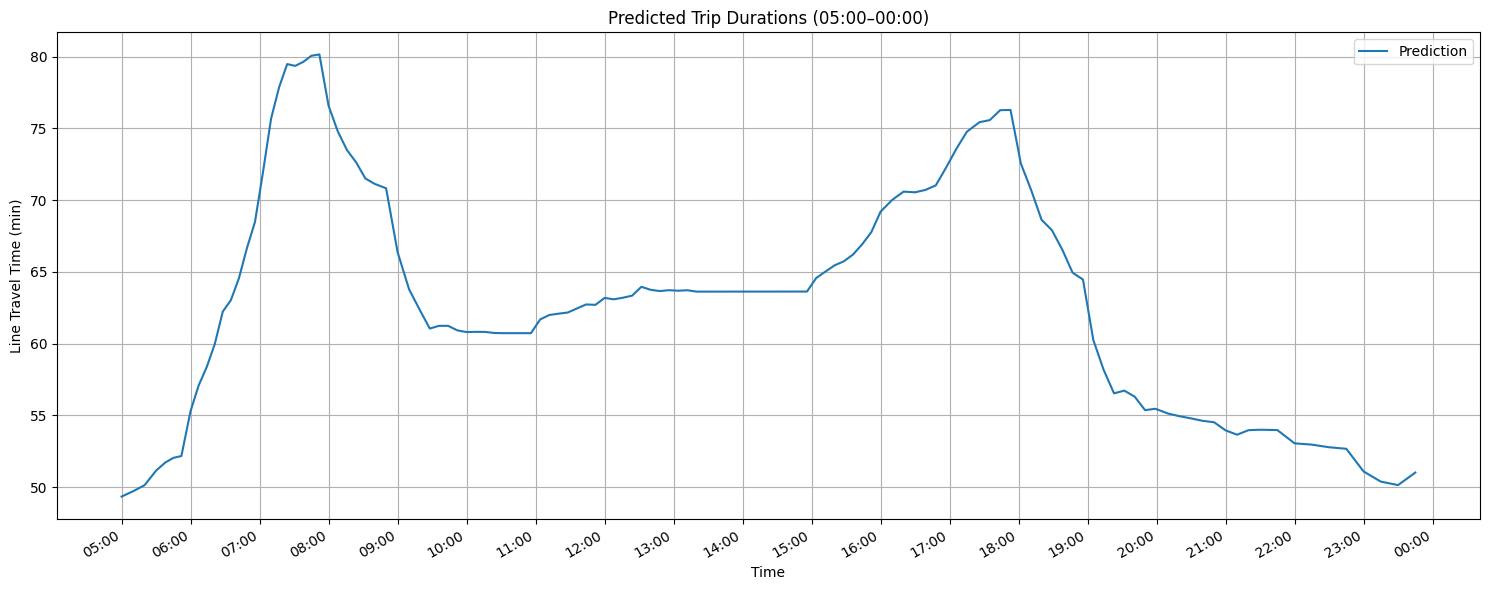

In [40]:
# Add hour information
df_temp["HOUR"] = df_temp["HATBASLANGICTARIHI"].dt.hour

# Filter data from 05:00 until before 00:00 (exclude midnight)
df_filtered = df_temp[(df_temp["HOUR"] >= 5) & (df_temp["HOUR"] < 24)]

import matplotlib.dates as mdates
plt.figure(figsize=(15, 6))

# Plot predicted travel durations
plt.plot(df_filtered["HATBASLANGICTARIHI"], df_filtered["PREDICTED_HATSURESI"], label="Prediction")

plt.title("Predicted Trip Durations (05:00–00:00)")
plt.xlabel("Time")
plt.ylabel("Line Travel Time (min)")

# Format x-axis to show hours and minutes
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.gcf().autofmt_xdate()

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
